In [31]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [32]:
from fastai.vision import *
from fastai.metrics import error_rate
import base64

In [33]:
bs = 64
path=Path("beano-images")

In [34]:
doc(ImageDataBunch.from_folder)
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, train='train', valid_pct=0.2, ds_tfms=tfms, size=224, num_workers=4).normalize(imagenet_stats)

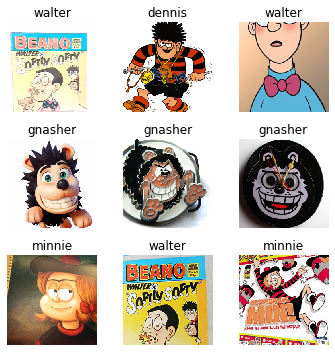

In [35]:
data.show_batch(rows=3, figsize=(5,5))

In [36]:
data.classes, len(data.classes),data.c, len(data.train_ds), len(data.valid_ds)

(['banana-man',
  'billy-whizz',
  'danny',
  'dennis',
  'fatty',
  'gnasher',
  'minnie',
  'plug',
  'roger-the-doger',
  'walter',
  'wilfred'],
 11,
 11,
 210,
 52)

In [37]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [39]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [40]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,3.744243,2.484927,0.615385,00:06
1,2.732768,0.948864,0.326923,00:04
2,1.994409,0.437194,0.173077,00:05
3,1.583826,0.285551,0.076923,00:04


In [41]:
learn.save("stage-1")

In [12]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


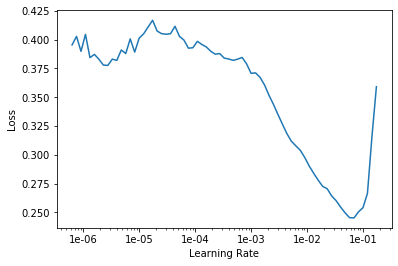

In [14]:
learn.recorder.plot()

In [16]:
learn.save("stage-1")

## learn using decent learning rate


In [24]:
learn.fit_one_cycle(8, 8e-03, 8e-02)

epoch,train_loss,valid_loss,error_rate,time
0,0.051392,0.060518,0.038462,00:05
1,0.054810,0.073578,0.038462,00:04
2,0.049400,0.083552,0.038462,00:05
3,0.042899,0.075723,0.038462,00:04
4,0.039525,0.072776,0.038462,00:04
5,0.038033,0.071697,0.038462,00:05
6,0.034923,0.071647,0.038462,00:05
7,0.031359,0.069507,0.038462,00:05


In [42]:
learn.save("prod")

## Interpretation

In [38]:
learn.load("prod")

Learner(data=ImageDataBunch;

Train: LabelList (210 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
banana-man,banana-man,banana-man,banana-man,banana-man
Path: beano-images;

Valid: LabelList (52 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
minnie,banana-man,dennis,roger-the-doger,minnie
Path: beano-images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=

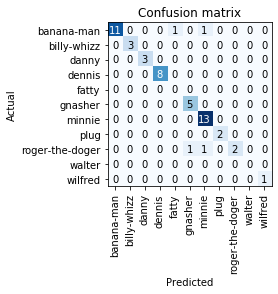

In [43]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

## Cleaning up


In [2]:
from fastai.widgets import *
# ds, idxs = interp.top_losses()
ds, idxs = DatasetFormatter().from_toplosses(learn, ds_type=DatasetType.Train)

# top_loss_paths = data.train_dl.x[idxs]
ImageCleaner(ds, idxs, Path("beano-images/train"))
# fd = FileDeleter(file_paths = top_loss_paths)

NameError: name 'learn' is not defined

In [26]:
data2 = ImageDataBunch.from_folder(path, data.classes, valid_pct=0.2, ds_tfms=tfms, size=224, num_workers=4).normalize(imagenet_stats)
learn2 = cnn_learner(data, models.resnet34)
learn2.load("stage-2")
pred_class, pred_index, outputs = learn2.predict(img)
pred_class

Category banana-man

In [ ]:
learn.load("prod")

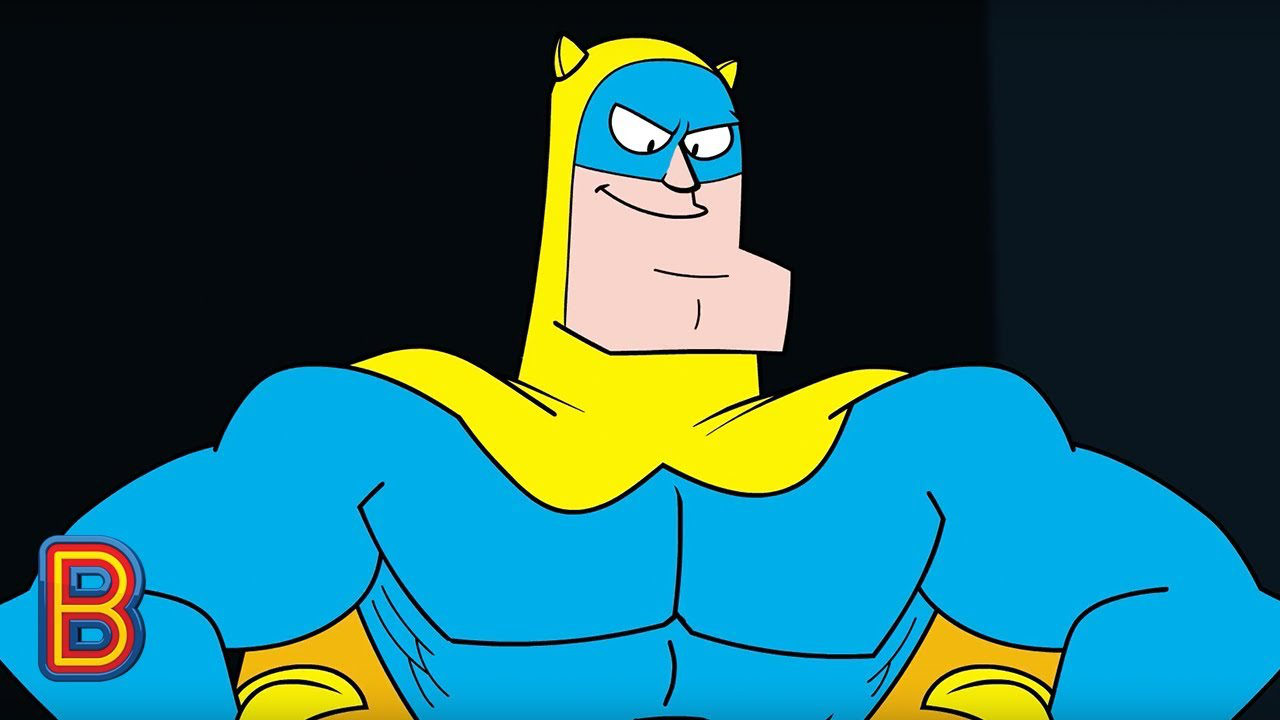

In [20]:
img = open_image("beano-images/train/banana-man/00000000.jpg")
img

In [13]:
save_texts(path/'models/classes.txt', data.classes)

## Productionise

In [45]:
learn.export('docker/model/export.pkl')


In [48]:
learn3 = load_learner('beano-images/docker/model')
# with open("beano-images/base64/bananaman00.jpg.b64", "rb") as binary_file:
with open("beano-images/base64/gnasher00.jpg.b64", "rb") as binary_file:
    # Read the whole file at once
    image_bytes_base64 = binary_file.read()
image_bytes = io.BytesIO(base64.b64decode(image_bytes_base64))
img = open_image(image_bytes)
# img = open_image("beano-images/train/banana-man/00000000.jpg")
pred_class, pred_index, outputs = learn3.predict(img)
pred_class

Category gnasher

In [16]:
tar_file=path/'models/prod.tar.gz'
model_file='prod.pth'
classes_file='classes.txt'
# create a tarfile with the exported model and classes text file
with tarfile.open(tar_file, 'w:gz') as f:
    f.add(path/f'models/{model_file}', arcname=model_file)
    f.add(path/f'models/{classes_file}', arcname=classes_file)